# M2.1 - Maxwell and common tangent construction

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.signal import argrelextrema

import niceplots
plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()

# Maxwell construction

In [2]:
a_tilda = 3.679

In [3]:
def vdw(V, a_tilda):
    p = (1./(V - 1.)) - (a_tilda / V**2) 
    return p

(1.0, 7.2)

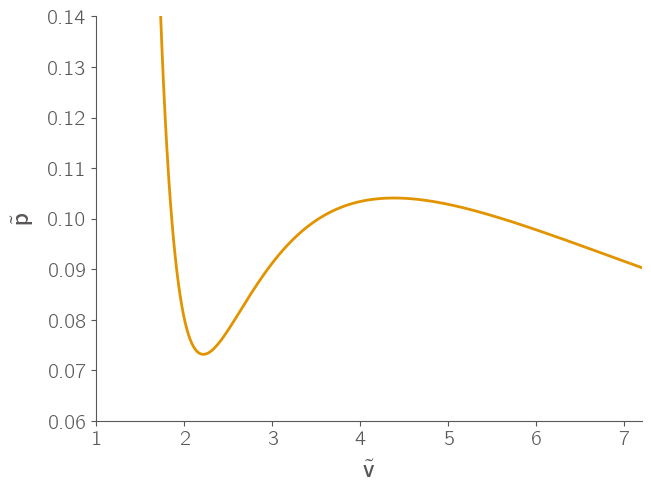

In [4]:
vol = np.linspace(1.2, 20, 1000)
plt.plot(vol, vdw(vol, a_tilda))
plt.xlabel(r"$\tilde v$")
plt.ylabel(r"$\tilde p$")
plt.ylim(0.06, 0.14)
plt.xlim(1, 7.2)

In [5]:
def get_Vlims(pr0, a_tilda):
    eos = np.poly1d((pr0, -(pr0+1), a_tilda, -a_tilda))
    roots = eos.r
    roots.sort()
    Vrmin, mid, Vrmax = roots
    return Vrmin, mid, Vrmax

def get_area_difference(Vr0, a_tilda):
    pr0 = vdw(Vr0, a_tilda)
    Vrmin, _, Vrmax = get_Vlims(pr0, a_tilda)
    return np.abs(quad(lambda vr: vdw(vr, a_tilda) - pr0, Vrmin, Vrmax)[0])


In [6]:
def vdw_maxwell(V, a_tilda, print_info=True):
    pr = vdw(V, a_tilda)
    iprmin = argrelextrema(pr, np.less)
    iprmax = argrelextrema(pr, np.greater)
    
    Vr0 = np.mean([V[iprmin], V[iprmax]])
    
    # Root finding by secant method
    Vr0 = newton(get_area_difference, Vr0, args=(a_tilda,))
    pr0 = vdw(Vr0, a_tilda)
    Vrmin, mid ,Vrmax = get_Vlims(pr0, a_tilda)
        
    

    area1 = quad(lambda vr: vdw(vr, a_tilda) - pr0, Vrmin, mid)[0]
    area2 = quad(lambda vr: vdw(vr, a_tilda) - pr0, mid, Vrmax)[0]
    if print_info:
        print("a =", a_tilda)
        print(f"Phase coexistence region : ({Vrmin}, {Vrmax})") 
        print(f"Phase coexistence pressure: {pr0}")
        print(f"Area of region 1: {area1}")
        print(f"Area of region 2: {area2}")

    # Set the pressure in the Maxwell construction region to constant pr0.
    pr[(V >= Vrmin) & (V <= Vrmax)] = pr0
    
    return pr, Vrmin, Vrmax, pr0


a = 3.679
Phase coexistence region : (1.8791300640513313, 6.360407637907907)
Phase coexistence pressure: 0.09561194266038814
Area of region 1: -0.01714781848451622
Area of region 2: 0.01714781848451615


(0.06, 0.14)

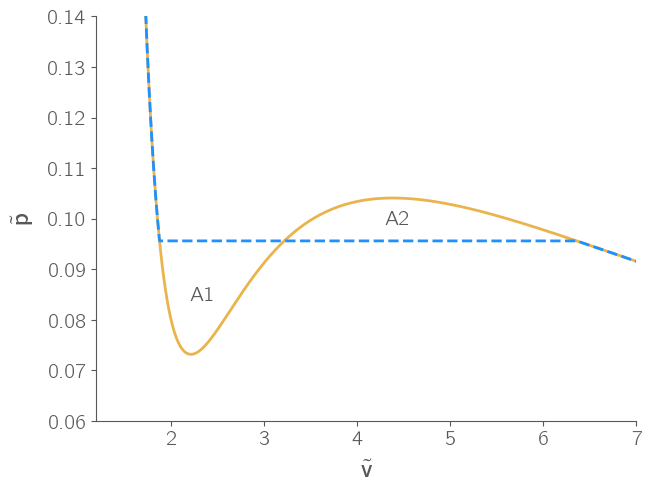

In [7]:
vol = np.linspace(1.2, 7, 1000)
a_tilda = 3.679

def plot_pV(a_tilda):
    ax.plot(vol, vdw(vol, a_tilda), lw=2, alpha=0.7)
    ax.plot(vol, vdw_maxwell(vol, a_tilda)[0], lw=2, linestyle="--")
    plt.xlabel(r"$\tilde v$")
    plt.ylabel(r"$\tilde p$")

fig, ax = plt.subplots()
ax.text(2.2, 0.085, "A1", va="center", fontsize=15)
ax.text(4.3, 0.1, "A2", va="center", fontsize=15)

plot_pV(a_tilda)
plt.ylim(0.06, 0.14)

(1.0, 10.0)

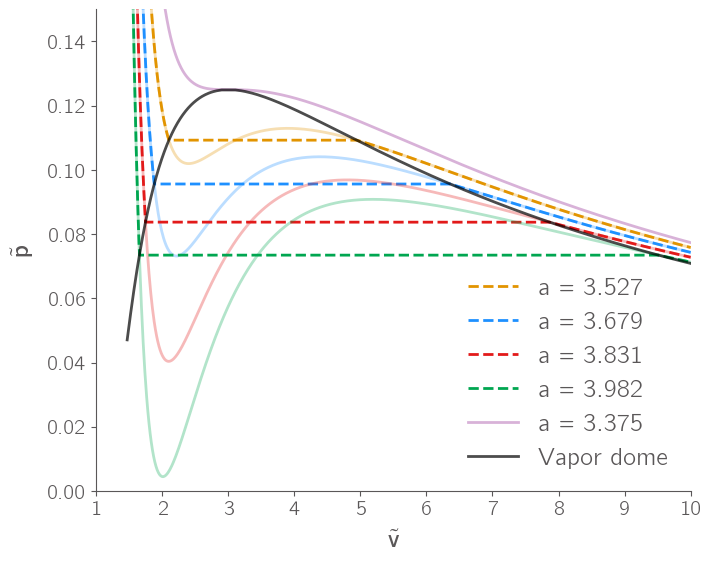

In [8]:
vol = np.linspace(1.2, 10, 1000)

def plot_pV(a_tilda, idx):
    ax.plot(vol, vdw(vol, a_tilda), lw=2, alpha=0.3, color=colors[idx])
    ax.plot(vol, vdw_maxwell(vol, a_tilda, False)[0], lw=2, linestyle="--", color=colors[idx], label=f"a = {a_tilda}")
    plt.xlabel(r"$\tilde v$")
    plt.ylabel(r"$\tilde p$")

fig, ax = plt.subplots(figsize=(7, 5.5))
N = 1000
stable_lims = np.zeros((N, 2))

for idx, a_tilda in enumerate([3.527, 3.679, 3.831, 3.982]):
    plot_pV(a_tilda, idx)

for idx, a_tilda in enumerate(np.linspace(3.376, 4.5, N//2)[::-1]):
    _, Vmin, Vmax, pr0 = vdw_maxwell(vol, a_tilda, print_info=False)
    stable_lims[idx] = [Vmin, pr0]
    stable_lims[N-idx-1] = [Vmax, pr0]

ax.plot(vol, vdw(vol, 3.375), lw=2, alpha=0.3, color=colors[6], label=f"a = 3.375")
ax.plot(stable_lims[:, 0], stable_lims[:, 1], color="black", alpha=0.7, label="Vapor dome")
plt.legend()
plt.ylim(0.0, 0.15)
plt.xlim(1.0, 10.0)

# Common tangent construction

(-2.5, -1.5)

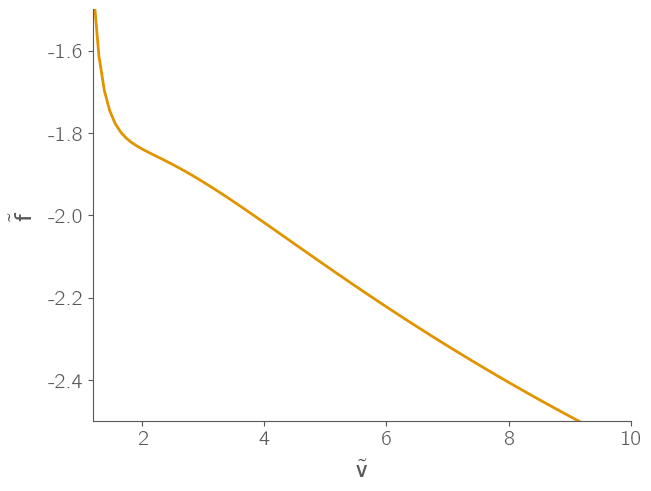

In [9]:
def helmholtz(V, a_tilda):
    f = np.log(1./(V-1.)) - a_tilda / V
    return f

def dfdV(V, a_tilda):
    return -1.0/(V-1.0) + a_tilda / V**2

vol = np.linspace(1.2, 10, 100)
a_tilda = 3.679
plt.plot(vol, helmholtz(vol, a_tilda))
plt.xlabel(r"$\tilde v$")
plt.ylabel(r"$\tilde f$")
plt.ylim(-2.5, -1.5)

In [10]:
from scipy.optimize import least_squares

def common_tangent(V, a_tilda):
    f = helmholtz(V, a_tilda)
    Vr0, Vr1 = (1.1, 7.0)

    def residuals(x, a_tilda):
        v1, v2 = x
        f1, f2 = helmholtz(v1, a_tilda), helmholtz(v2, a_tilda)
        fp1, fp2 = dfdV(v1, a_tilda), dfdV(v2, a_tilda)
        sec = (f2 - f1)/(v2 - v1)

        return np.array([fp1 - fp2, sec - fp1])

    lb = np.array([1.000001, 1.00001])
    ub = np.array([V[-1], V[-1]])
    x0 = np.array([Vr0, Vr1])

    sol = least_squares(residuals, x0, bounds=(lb, ub), xtol=1e-6, ftol=1e-6, gtol=1e-12, args=(a_tilda,))
    v1, v2 = sol.x
    m = dfdV(v1, a_tilda)
    c = helmholtz(v1, a_tilda) - m*v1

    plt.scatter([v1, v2], helmholtz(np.array([v1, v2]), a_tilda), marker="x", lw=2, color="red")

    print(f"Phase coexistence region : ({v1}, {v2})")
    print(f"Phase coexistence pressure: {abs(m)}")
    idx1 = np.where(V <= v1)[0][-1]
    idx2 = np.where(V >= v2)[0][0]

    f[idx1:idx2] = m * V[idx1:idx2] + c
    return f

Phase coexistence region : (1.8791300640513295, 6.36040763790791)
Phase coexistence pressure: 0.09561194266038808


(-2.5, -1.5)

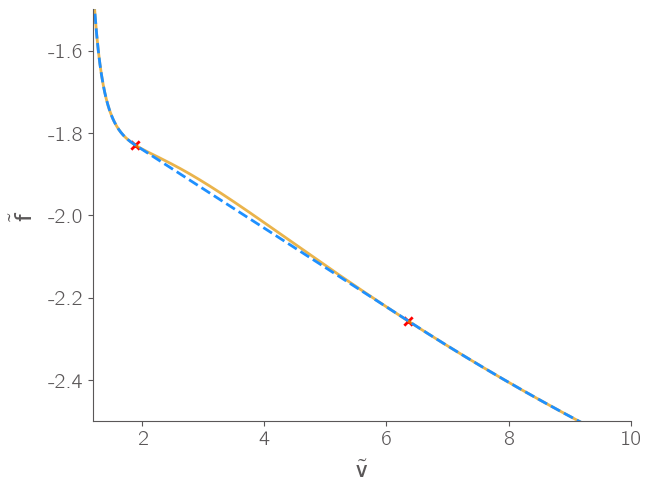

In [11]:
vol = np.linspace(1.2, 10, 1000)

def plot_pV(a_tilda):
    ax.plot(vol, helmholtz(vol, a_tilda), lw=2, alpha=0.7)
    ax.plot(vol, common_tangent(vol, a_tilda), lw=2, linestyle="--")
    plt.xlabel(r"$\tilde v$")
    plt.ylabel(r"$\tilde f$")
    
fig, ax = plt.subplots()
plot_pV(a_tilda)
plt.ylim(-2.5, -1.5)

a =  3.527
Phase coexistence region : (2.100805901929695, 4.94230827856587)
Phase coexistence pressure: 0.10926561271232049
a =  3.679
Phase coexistence region : (1.8791300640513295, 6.36040763790791)
Phase coexistence pressure: 0.09561194266038808
a =  3.831
Phase coexistence region : (1.7461847655421443, 7.86407182424141)
Phase coexistence pressure: 0.0837395590973482
a =  3.982
Phase coexistence region : (1.654052755077713, 9.514092556372724)
Phase coexistence pressure: 0.07346105781834278


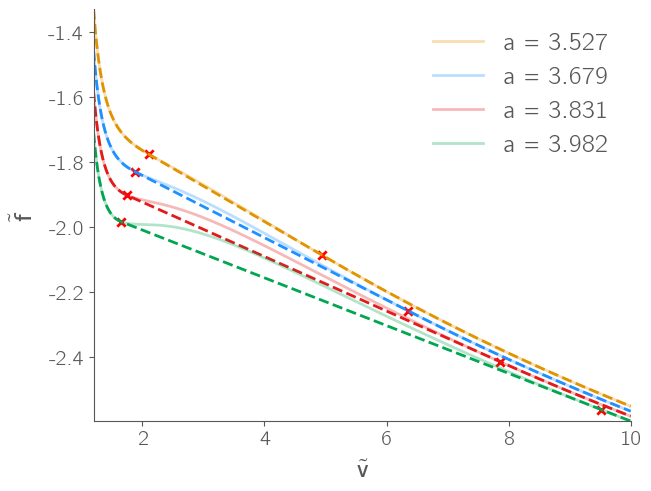

In [12]:
vol = np.linspace(1.2, 10, 1000)

def plot_pV(a_tilda, idx):
    ax.plot(vol, helmholtz(vol, a_tilda), lw=2, alpha=0.3, color=colors[idx], label=f"a = {a_tilda}")
    ax.plot(vol, common_tangent(vol, a_tilda), lw=2, linestyle="--", color=colors[idx])
    plt.xlabel(r"$\tilde v$")
    plt.ylabel(r"$\tilde f$")

fig, ax = plt.subplots()
for idx, a_tilda in enumerate([3.527, 3.679, 3.831, 3.982]):
    print("a = ", a_tilda)
    plot_pV(a_tilda, idx)

plt.legend()
# plt.ylim(0.0, 0.2)